In [2]:
from spacepy import pycdf
from PIL import Image, ImageOps
import glob
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import sys

In [3]:
cdf = pycdf.CDF("fsmi_asf_data_2008-02-02/thg_l1_asf_fsmi_2008020203_v01.cdf")
cdf_dat = cdf.copy()

In [4]:
cdf.attrs

<gAttrList:
ADID_ref: NSSD0110 [CDF_CHAR]
Acknowledgement: NASA Contract NAS5-02099 [CDF_CHAR]
Data_type: ASF>All Sky Imager, Full resolution images, High resolution [CDF_CHAR]
Data_version: 1 [CDF_CHAR]
Descriptor: FSMI>Fort Smith Canada [CDF_CHAR]
Discipline: Space Physics>Magnetospheric Science [CDF_CHAR]
            Space Physics>Ionospheric Science [CDF_CHAR]
File_naming_convention: source_datatype_descriptor [CDF_CHAR]
Generated_by: Harald Frey [CDF_CHAR]
Generation_date: 2006-10-24 [CDF_CHAR]
HTTP_LINK: http://sprg.ssl.berkeley.edu/themis [CDF_CHAR]
           http://aurora.phys.ucalgary.ca/themis [CDF_CHAR]
Instrument_type: Ground-Based VLF/ELF/ULF, Photometrics [CDF_CHAR]
LINK_TEXT: http://sprg.ssl.berkeley.edu/themis [CDF_CHAR]
           http://aurora.phys.ucalgary.ca/themis [CDF_CHAR]
LINK_TITLE: THEMIS GBO portal [CDF_CHAR]
            THEMIS-Canada portal [CDF_CHAR]
Logical_file_id: thg_l1_asf_fsmi_2008020203_v01 [CDF_CHAR]
Logical_source: thg_l1_asf_fsmi [CDF_CHAR]
Logic

In [5]:
print(cdf)

range_epoch: CDF_EPOCH [2]
thg_asf_fsmi: CDF_UINT2 [1200, 256, 256]
thg_asf_fsmi_column: CDF_UINT2 [256] NRV
thg_asf_fsmi_epoch: CDF_EPOCH [1200]
thg_asf_fsmi_epoch0: CDF_EPOCH [] NRV
thg_asf_fsmi_row: CDF_UINT2 [256] NRV
thg_asf_fsmi_tend: CDF_REAL8 [1200]
thg_asf_fsmi_time: CDF_REAL8 [1200]


In [6]:
images = np.array(cdf_dat['thg_asf_fsmi'])
times = np.array(cdf_dat['thg_asf_fsmi_epoch'])

In [7]:
def process_images(images):
    processed_images = []
    for image in images:
        processed_image = image - np.percentile(image, 1)
        processed_image = processed_image / np.percentile(image, 99)
        processed_image = np.maximum(np.zeros(processed_image.shape), processed_image)
        processed_image = np.minimum(np.ones(processed_image.shape), processed_image)
        processed_images.append(processed_image)
    return np.array(processed_images)

In [24]:
def make_png_files(directory, pixels, times):
    images = process_images(pixels)
    
    if not os.path.exists(directory):
        os.mkdir(directory)
    
    for image, time in zip(images, times):
        time_str = time.strftime('%Y%m%d%H%M%S')
        
        image = (image * 255).astype(np.uint8)
                
        im = Image.fromarray(image)
                
        im = ImageOps.grayscale(im)
        
        im.save(f'{directory}/{time_str}.png')

In [25]:
make_png_files("./fsmi_asf_data_2008-02-02/fsmi_asf_2008020203_images", images, times)

In [8]:
sys.path.append(os.path.abspath("/Users/jeffreysung/Documents/Cal/ssl/substorm-prediction/tame/"))
sys.path.append(os.path.abspath("/Users/jeffreysung/Documents/Cal/ssl/substorm-prediction/tame/dataHandler"))
from dataHandler import AsimClassifier
torch_data_location = "/Users/jeffreysung/Documents/Cal/ssl/substorm-prediction/tame/data/torch/"
clf = AsimClassifier(torch_path=torch_data_location)
image_files = glob.glob("/Users/jeffreysung/Documents/Cal/ssl/substorm-prediction/fsmi_asf_data_2008-02-02/fsmi_asf_2008020203_images/*.png")

In [9]:
results = clf.classify_images(image_files)

2022-10-27 02:21:59,679 - logger - INFO - Device set to cpu
2022-10-27 02:21:59,679 - logger - INFO - loading pretrained torchvision model
/Users/jeffreysung/mambaforge/envs/substorm/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/jeffreysung/mambaforge/envs/substorm/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
2022-10-27 02:21:59,718 - logger - INFO - Extracting features


 |==================================================| 100.000% 


In [10]:
results['time'] = results['file'].apply(lambda x: int(re.findall(r'([\d]+)\.png$', x)[0])).sort_values()
results = results.sort_values('time')
results['time'] = times
results = results.reset_index(drop=True)
results

,file,pred,class_0,class_1,class_2,class_3,class_4,class_5,feat_0,feat_1,...,feat_991,feat_992,feat_993,feat_994,feat_995,feat_996,feat_997,feat_998,feat_999,time
0,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,0,0.833408,0.066296,0.042348,0.031211,0.003647,0.023090,0.417088,1.269062,...,0.988254,-0.123808,0.843180,1.180724,0.738386,-0.826681,3.096364,-3.443031,-2.955891,2008-02-02 03:00:00.016
1,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,0,0.815027,0.066761,0.044127,0.040574,0.004814,0.028696,0.537690,1.286304,...,0.974371,-0.315083,0.444256,0.873913,0.481683,-0.987578,2.444373,-3.385630,-3.127020,2008-02-02 03:00:03.056
2,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,0,0.790265,0.082441,0.063584,0.032111,0.003502,0.028098,0.694059,1.036068,...,0.608064,-0.713781,0.723566,0.774171,0.579010,-0.834025,2.759641,-3.584901,-2.460748,2008-02-02 03:00:06.056
3,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,0,0.869005,0.050985,0.037669,0.019162,0.001707,0.021473,0.390448,0.978108,...,0.961331,-0.429062,0.964842,1.320595,0.847180,-0.778828,2.883193,-3.561198,-2.689919,2008-02-02 03:00:09.046
4,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,0,0.826971,0.070036,0.054138,0.025108,0.002507,0.021240,0.821930,1.207379,...,1.020223,-0.730767,1.126391,0.422891,0.443267,-1.169100,2.511946,-3.500768,-2.570672,2008-02-02 03:00:12.046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,1,0.049818,0.901417,0.012743,0.026980,0.000224,0.008817,-1.124255,0.413999,...,-0.116766,1.453136,1.131473,1.511506,-0.052415,-0.550465,3.543882,-2.602812,-3.584011,2008-02-02 03:59:45.036
1196,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,1,0.028250,0.944623,0.011410,0.014278,0.000133,0.001306,-1.010583,0.375132,...,0.118806,0.736169,1.535245,1.479197,0.290260,-0.485764,3.225814,-2.129452,-3.269636,2008-02-02 03:59:48.026
1197,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,1,0.042205,0.932733,0.010219,0.012378,0.000102,0.002363,-0.829888,0.625171,...,-0.018070,1.663681,1.391688,1.916909,-0.101023,-0.373787,3.104263,-2.306571,-3.576681,2008-02-02 03:59:51.016
1198,/Users/jeffreysung/Documents/Cal/ssl/substorm-...,1,0.042502,0.943132,0.007464,0.005571,0.000042,0.001289,-0.849549,0.561109,...,0.172127,1.465386,1.527878,2.032602,-0.286937,-0.448969,3.121051,-2.377574,-3.822105,2008-02-02 03:59:54.026


In [13]:
def plot_probabilities_over_time(results):
    fig = plt.figure(figsize=(24, 8))
    ax = fig.gca()
    plt.title("Aurora Classification Results: FSMI ASF 2008-02-03 3:00-4:00")
    plt.ylabel("Probability of Class")
    plt.xlabel("Time")
    plt.ylim(
        ymin=0,
        ymax=1
    )
    plt.plot(results['time'], results['class_0'], label='arc')
    plt.plot(results['time'], results['class_1'], label='diffuse')
    plt.plot(results['time'], results['class_2'], label='discrete')
    plt.plot(results['time'], results['class_3'], label='cloud')
    plt.plot(results['time'], results['class_4'], label='moon')
    plt.plot(results['time'], results['class_5'], label='clear')
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()

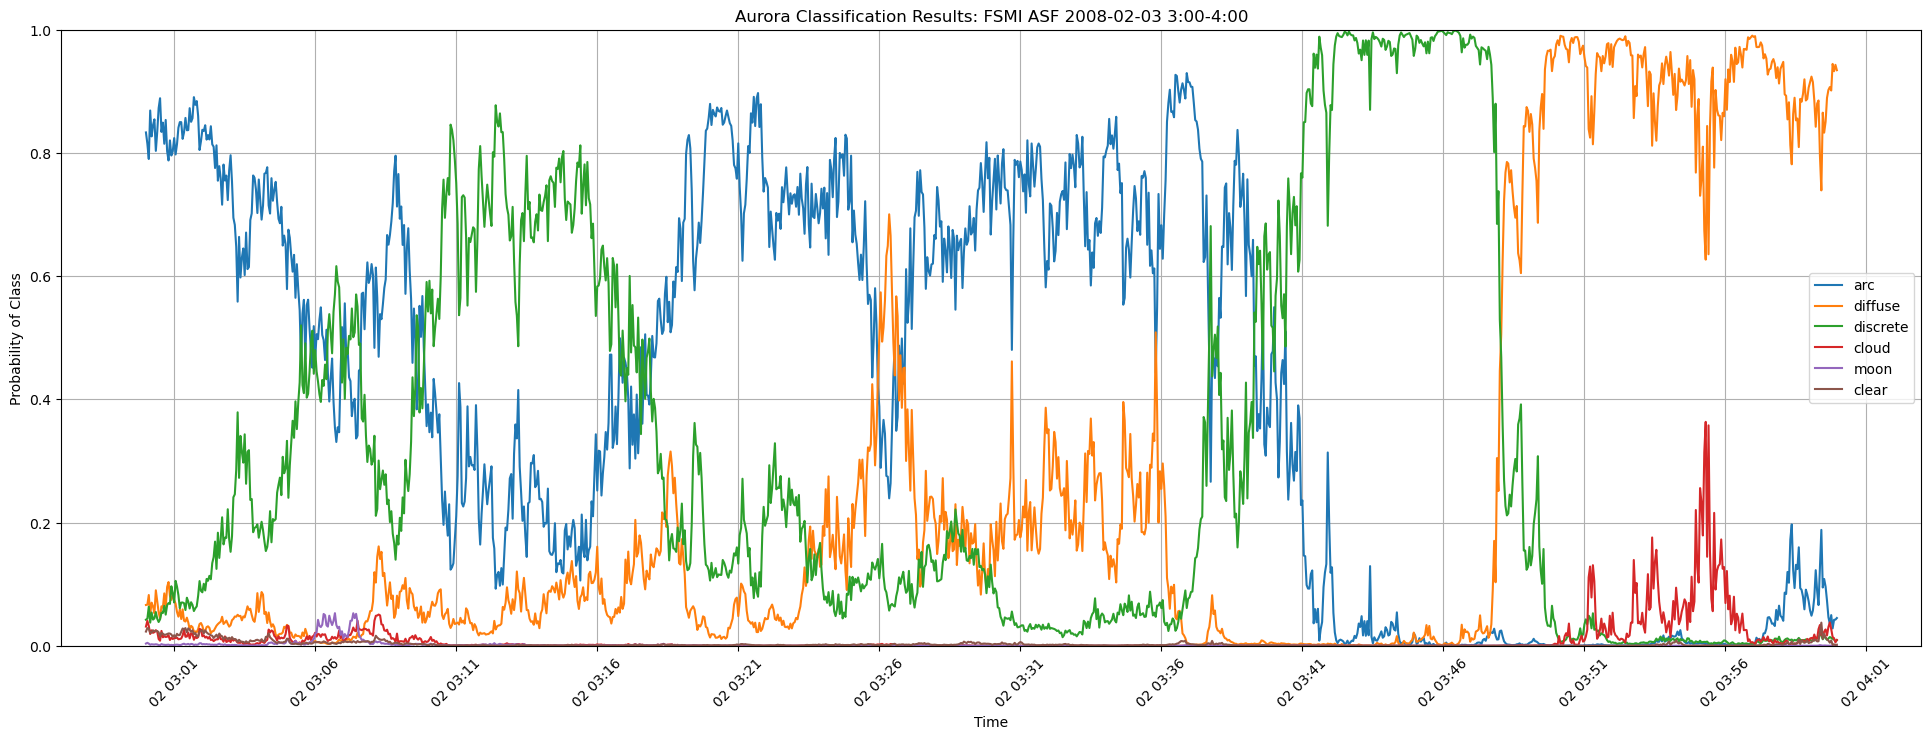

In [14]:
plot_probabilities_over_time(results)

In [15]:
# input integer between 0 and len(image_list) - 1
def display_single_result(image_list, results, index):
    im = Image.open(image_list[index])
    plt.imshow(im, cmap='gray')
    plt.xticks(())
    plt.yticks(())
    class_probabilities = [str(results.iloc[index]["class_"+str(i)]*100) for i in range(6)]
    print("arc with probability " + class_probabilities[0] + "%")
    print("diffuse with probability " + class_probabilities[1] + "%")
    print("discrete with probability " + class_probabilities[2] + "%")
    print("cloud with probability " + class_probabilities[3] + "%")
    print("moon with probability " + class_probabilities[4] + "%")
    print("clear sky with probability " + class_probabilities[5] + "%")

arc with probability 57.90817325915787%
diffuse with probability 3.393987509995954%
discrete with probability 33.26707973289824%
cloud with probability 3.2616646563814453%
moon with probability 1.011945547577408%
clear sky with probability 1.157149293989122%


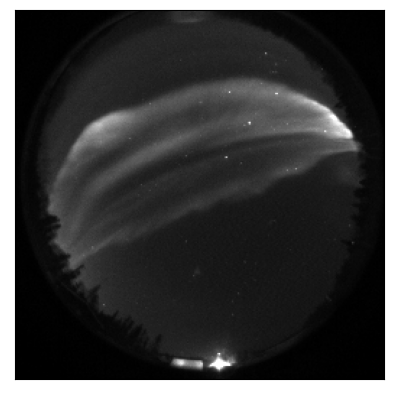

In [16]:
display_single_result(image_files, results, 100)

In [21]:
def plot_classes_over_time(results):
    fig = plt.figure(figsize=(24, 8))
    ax = fig.gca()
    plt.title("Classes Predicted: FSMI ASF 2008-02-03 3:00-4:00")
    plt.ylabel("Class")
    plt.xlabel("Time")
    plt.ylim(ymin=-1, ymax=5)
    plt.plot(results['time'], results['pred'])
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
    plt.xticks(rotation=45)    


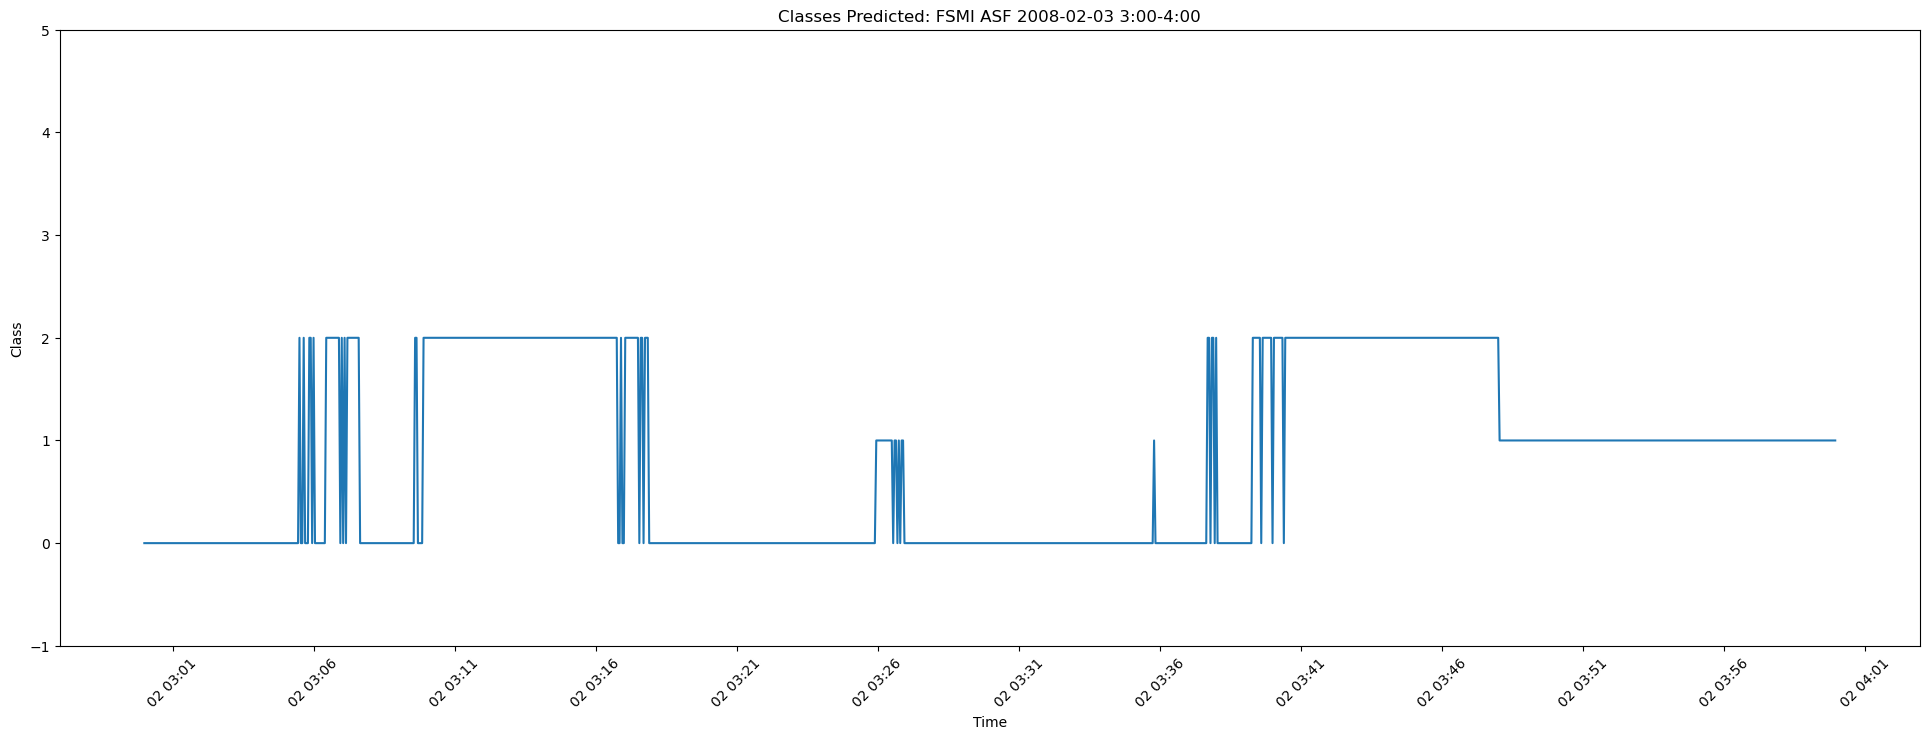

In [22]:
plot_classes_over_time(results)